# PK Risk Fairness Evaluation Walkthrough

This notebook demonstrates how we measured the proportion of the PK risk each racial group bears when daily sharing updated patient-level surveillance data under a policy. The estimation process is very similar to that of the general PK risk estimation.

In [1]:
# load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data
First, we upload the example case counts and census data.

In [2]:
# import disease case counts

df = pd.read_csv('example_counts_data.csv').set_index('fips')
census = pd.read_csv("example_census_data.csv")

# Code

In [3]:
def generalize(df, ind_col = "fips", ages = False, races = False, sexes = False, ethnicities = False):
    """
    Generalizes census data for age, race, sex, and/or ethnicity.
    """
    temp = df.copy()
    
    # generalize bin values
    if ages:
        temp['age'] = pd.cut(temp['age'],ages, right=False) 
    if races:
        for race_gen in races:
            for key, value in race_gen.items():
                for val in value:
                    temp.loc[temp.race == val, 'race'] = key          
    if sexes:
        temp['sex'] = 'both_sex'
    if ethnicities:
        temp['ethnicity'] = 'both_ethnicity'
        
    # groupby and sum values per demographic bin
    new_temp = temp.groupby([ind_col, 'sex', 'race', 'age', 'ethnicity'])\
                    .agg({'counts':'sum'})\
                    .astype({'counts':int})\
                    .reset_index()
    # label each bin
    new_temp['bins'] = new_temp['sex'] + \
                        ',' + new_temp['race'] + \
                        ',' + new_temp['ethnicity'] + \
                        ',' + new_temp['age']\
                        .astype(str)
    
    return new_temp.pivot_table(index = ind_col, columns = 'bins', values = 'counts')

The PK_fair_race class is defined below. It differs from the privacy_risk_estimation_PK class in that it requires as input boolean lists defining which bins in the demographic distribution correspond to each racial group.

In [4]:
class PK_fair_race:
    
    """
    Uses Monte Carlo sampling techniques (without replacement) to estimate the longitudinal PK risk
    of a sharing patient-level pandemic data on a consistent basis (e.g., daily or weekly)
    for a user-specified k value. The PK risk is estimated for each time point in a given county,
    when sharing data under a specific data sharing policy (which defines the demographic bins). 
    The PK risk values are calculated on a lagged period of infected individuals.
    
    Input:
    counts = Dataframe of the case counts per time period (e.g. daily counts of new disease cases from
             the JHU COVID-19 surveillance data). Must include the fips code in the index and the columns
             must be date values.
    gen_census = The generalized census, i.e., the output of the generalize function above for the
                 specified fips code.
    fips = The fips code of interest. Must be of the same format of the counts dataframe index column.
    n_sims = The number of simulations to be run in the experiment.
    k = The k value to be used in the PK risk calculation. Default is 10.
    period_size = The size of the lagging period to be used for calculating the PK risk values.
                  Default value is 3.
    
    Output:
    self.*race*_PK_prop = Dataframe where each row is a unique simulation and each column is a time period.
                       Each cell value corresponds to the proportion of the total PK risk in the lagging
                       period the corresponding racial group bears. There is a dataframe for each racial
                       group present in the US census data.
    """
    
    def __init__(self, counts, gen_census, fips, n_sims, k=10, period_size=3, rng=np.random.default_rng(),
                 black = [], asian = [], alaska = [], pacific = [], mixed = [], other = [], white = []):
        
        self.counts = counts.loc[fips,:].values
        self.dates = counts.columns
        self.census = gen_census
        self.n_bins = len(self.census)
        self.n_sims = n_sims
        self.xk = np.arange(self.n_sims)
        self.k = k
        self.period_size = period_size
        self.recent_cases = []
        self.rng = rng
        
        # all races
        self.PK = pd.DataFrame(columns = self.dates)
        
        # race-specific
        if len(black) > 0:
            self.black = black
            self.black_PK_prop = pd.DataFrame(columns = self.dates)
            self.black_include = True
        else:
            self.black_include = False
        if len(asian) > 0:
            self.asian = asian
            self.asian_PK_prop = pd.DataFrame(columns = self.dates)
            self.asian_include = True
        else:
            self.asian_include = False
        if len(alaska) > 0:
            self.alaska = alaska
            self.alaska_PK_prop = pd.DataFrame(columns = self.dates)
            self.alaska_include = True
        else:
            self.alaska_include = False
        if len(pacific) > 0:
            self.pacific = pacific
            self.pacific_PK_prop = pd.DataFrame(columns = self.dates)
            self.pacific_include = True
        else:
            self.pacific_include = False
        if len(mixed) > 0:
            self.mixed = mixed
            self.mixed_PK_prop = pd.DataFrame(columns = self.dates)
            self.mixed_include = True
        else:
            self.mixed_include = False
        if len(other) > 0:
            self.other = other
            self.other_PK_prop = pd.DataFrame(columns = self.dates)
            self.other_include = True
        else:
            self.other_include = False
        if len(white) > 0:
            self.white = white
            self.white_PK_prop = pd.DataFrame(columns = self.dates)
            self.white_include = True
        else:
            self.white_include = False
        
    def create_full_population(self):
        
        """
        Creates full population from generalized census counts.
        """
        
        self.full_pop = np.tile(self.census.values, (self.n_sims,1))
        
    def get_infected_population(self):
        
        """
        Creates the infected population for each simulation.
        """
        
        ppl = self.full_pop[0]
        self.indexed_pop = np.concatenate(list(map(lambda i: np.repeat(i, ppl[i]), range(len(ppl)))),axis=0)
        
        # if more than one equivalence class, randomly choose infected from full population
        if len(self.full_pop[0]) > 1:
            self.choose_infected()
        else:
            self.choose_infected(False)
        
    def choose_infected(self, true_shuffle=True):
        
        """
        Monte Carlo random samples without replacement the infected indviduals from the population.
        """
        
        total_ppl = self.counts.sum()
        
        if true_shuffle:
            self.infected = np.stack(list(map(lambda sim: self.rng.choice(self.indexed_pop,
                                                                          size=total_ppl,
                                                                          replace=False),
                                         range(self.n_sims))), axis=0)
        else:
            row = self.indexed_pop[:total_ppl]
            self.infected = np.tile(row, (self.n_sims, 1))
            
        #del self.indexed_pop
    
    def count_per_bin(self):
            
        """
        Counts the number of infected individuals in each demographic bin for the current time
        period's infections.
        """
        
        # empty array for the time period's newest per bin per simulation
        self.new_cases = np.zeros((self.n_sims, self.n_bins))
        
        # split shuffled values on sample size
        samples, self.infected = np.split(self.infected, [self.n_ppl], axis=1)
        
        # add infected people per bin
        for i in samples.T:
            self.new_cases[self.xk,i] += 1
    
    def drop_frame(self):
        
        """
        Removes the oldest set of infections from recent cases.
        """
        
        self.recent_cases.pop(0)
        
    def add_frame(self):
        
        """
        Adds the newest set of infections to recent cases.
        """
        
        self.recent_cases.append(self.new_cases)
    
    def update_recent_cases(self):
        
        """
        Updates the list of recent cases reported within the lagging period.
        """
        
        if len(self.recent_cases) == self.period_size:
            self.drop_frame()
            self.add_frame()
        else:
            self.add_frame()
        self.get_cases_in_period()
        
    def get_cases_in_period(self):
        
        """
        Sums the number of reported cases in each demographic bin with a diagnosis date within
        the lagging period.
        """
        
        self.cases_in_period = sum(self.recent_cases)
    
    def calc_PK_risk(self):
        
        """
        Calculates the PK risk on the cases reported in the lagging period.
        """
        
        n_ppl = self.cases_in_period.sum(axis=1)[0]
        if n_ppl == 0:
            return [0] * self.n_sims
        else:
            risk = np.ndarray((self.n_sims, self.k))
            for i in range(1, self.k+1):
                risk[:,(i-1)] = np.count_nonzero(self.cases_in_period == i, axis=1) * i
            return risk.sum(axis=1)/n_ppl
        
    def calc_proportion_PK(self, field):
        
        """
        Calculates the proportion of the PK risk corresponding to a given race.
        """
        
        n_ppl = self.cases_in_period.sum(axis=1)[0]
        if n_ppl == 0:
            return [0] * self.n_sims
        else:
            with np.errstate(divide='ignore', invalid='ignore'):
                field_k = np.ndarray((self.n_sims, self.k))
                all_k = np.ndarray((self.n_sims, self.k))
                for i in range(1, self.k+1):
                    field_k[:,(i-1)] = np.count_nonzero(self.cases_in_period[:,field] == i, axis=1) * i
                    all_k[:,(i-1)] = np.count_nonzero(self.cases_in_period == i, axis=1) * i
                return field_k.sum(axis=1)/all_k.sum(axis=1)
        
    def run_full_simulation(self):
        
        """
        Runs the full simulation.
        """
        
        self.create_full_population()
        self.get_infected_population()
        
        fill_zeros = True
        
        for i in range(len(self.dates)):
            date = self.dates[i]
            self.n_ppl = self.counts[i]
            
            if fill_zeros:
                if (self.n_ppl == 0):
                    self.PK[date] = [0] * self.n_sims
                    if self.black_include:
                        self.black_PK_prop[date] = [0] * self.n_sims
                    if self.asian_include:
                        self.asian_PK_prop[date] = [0] * self.n_sims
                    if self.alaska_include:
                        self.alaska_PK_prop[date] = [0] * self.n_sims
                    if self.pacific_include:
                        self.pacific_PK_prop[date] = [0] * self.n_sims
                    if self.mixed_include:
                        self.mixed_PK_prop[date] = [0] * self.n_sims
                    if self.other_include:
                        self.other_PK_prop[date] = [0] * self.n_sims
                    if self.white_include:
                        self.white_PK_prop[date] = [0] * self.n_sims
                else:
                    self.count_per_bin()
                    self.update_recent_cases()
                    self.PK[date] = self.calc_PK_risk()
                    if self.black_include:
                        self.black_PK_prop[date] = self.calc_proportion_PK(self.black)
                    if self.asian_include:
                        self.asian_PK_prop[date] = self.calc_proportion_PK(self.asian)
                    if self.alaska_include:
                        self.alaska_PK_prop[date] = self.calc_proportion_PK(self.alaska)
                    if self.pacific_include:
                        self.pacific_PK_prop[date] = self.calc_proportion_PK(self.pacific)
                    if self.mixed_include:
                        self.mixed_PK_prop[date] = self.calc_proportion_PK(self.mixed)
                    if self.other_include:
                        self.other_PK_prop[date] = self.calc_proportion_PK(self.other)
                    if self.white_include:
                        self.white_PK_prop[date] = self.calc_proportion_PK(self.white)
                    fill_zeros = False
                
            else:
                self.count_per_bin()
                self.update_recent_cases()
                self.PK[date] = self.calc_PK_risk()
                if self.black_include:
                    self.black_PK_prop[date] = self.calc_proportion_PK(self.black)
                if self.asian_include:
                    self.asian_PK_prop[date] = self.calc_proportion_PK(self.asian)
                if self.alaska_include:
                    self.alaska_PK_prop[date] = self.calc_proportion_PK(self.alaska)
                if self.pacific_include:
                    self.pacific_PK_prop[date] = self.calc_proportion_PK(self.pacific)
                if self.mixed_include:
                    self.mixed_PK_prop[date] = self.calc_proportion_PK(self.mixed)
                if self.other_include:
                    self.other_PK_prop[date] = self.calc_proportion_PK(self.other)
                if self.white_include:
                    self.white_PK_prop[date] = self.calc_proportion_PK(self.white)
        
    def get_stats(self, df, percentiles):
        
        """
        Helper function to generate summary statistics on the simulation results.
        """
        
        stats = np.percentile(df, percentiles, axis=0)
        results = pd.DataFrame()
        results['date'] = self.dates
        results['lower'] = stats[0, :]
        results['mean'] = np.mean(df, axis=0).values
        results['upper'] = stats[1, :]

        return results

# Full simulation example
The example mimics that of the PK risk estimation walkthrough. that again uses Davidson County. The policy generalizes age into 15-yeare age bins [0-15), [15-30), [30-45), [45-60), [60-75), [75-90), and 90+. Sex and ethnicity are suppressed. Race is not generalized nor suppressed. This results in 49 potential demographic bins in each county, according to the policy.

In [5]:
gc = generalize(census,
                ages = [0, 15, 30, 45, 60, 75, 90, 120],
                sexes = True,
                ethnicities = True)

gc

bins,"both_sex,a,both_ethnicity,[0, 15)","both_sex,a,both_ethnicity,[15, 30)","both_sex,a,both_ethnicity,[30, 45)","both_sex,a,both_ethnicity,[45, 60)","both_sex,a,both_ethnicity,[60, 75)","both_sex,a,both_ethnicity,[75, 90)","both_sex,a,both_ethnicity,[90, 120)","both_sex,ai_an,both_ethnicity,[0, 15)","both_sex,ai_an,both_ethnicity,[15, 30)","both_sex,ai_an,both_ethnicity,[30, 45)",...,"both_sex,other,both_ethnicity,[60, 75)","both_sex,other,both_ethnicity,[75, 90)","both_sex,other,both_ethnicity,[90, 120)","both_sex,w,both_ethnicity,[0, 15)","both_sex,w,both_ethnicity,[15, 30)","both_sex,w,both_ethnicity,[30, 45)","both_sex,w,both_ethnicity,[45, 60)","both_sex,w,both_ethnicity,[60, 75)","both_sex,w,both_ethnicity,[75, 90)","both_sex,w,both_ethnicity,[90, 120)"
fips,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2464,3014,2619,2492,2591,2375,2176
2,0,0,0,0,0,0,0,1780,1918,1946,...,0,0,0,0,0,0,0,0,0,0
3,2407,2340,2210,2387,2478,2457,2111,531,510,506,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1429,1448,1269,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,1001,994,806,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,8854,10968,9191,13841,10036,4899,2063
7,0,0,0,0,0,0,0,1968,1900,2074,...,0,0,0,0,0,0,0,0,0,0
8,2402,2258,2301,2360,2374,2339,2110,519,632,556,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,1367,1375,1425,0,0,0,0,0,0,0


After generalizing the demographic distribution, we determine which bins correspond to each racial group. Under this policy, there are only four potential race values.

In [6]:
# get racial groups indices

x = gc.loc[gc.index[0],:].reset_index()
dems = x.bins.str.split(",",expand=True)
dems.columns = ['gender','race','ethnicity','age1', 'age2']

black = dems.race == 'b'
asian = dems.race == 'a'
other = dems.race =='other'
white = dems.race == 'w'

In [7]:
%%time
# estimate risk proportions

fip = 1
wind_size = 5 # 5-day lagging window

mc = PK_fair_race(counts = df.loc[fip,:].to_frame().transpose(),
                                    gen_census = gc.loc[fip,:],
                                    fips = fip,
                                    n_sims = 1000,
                                    k = 10,
                                    period_size = wind_size,
                                    black=black, asian=asian, other=other, white=white)

mc.run_full_simulation()

CPU times: user 1.01 s, sys: 28.7 ms, total: 1.04 s
Wall time: 1.04 s


Text(0.5, 0, 'Date')

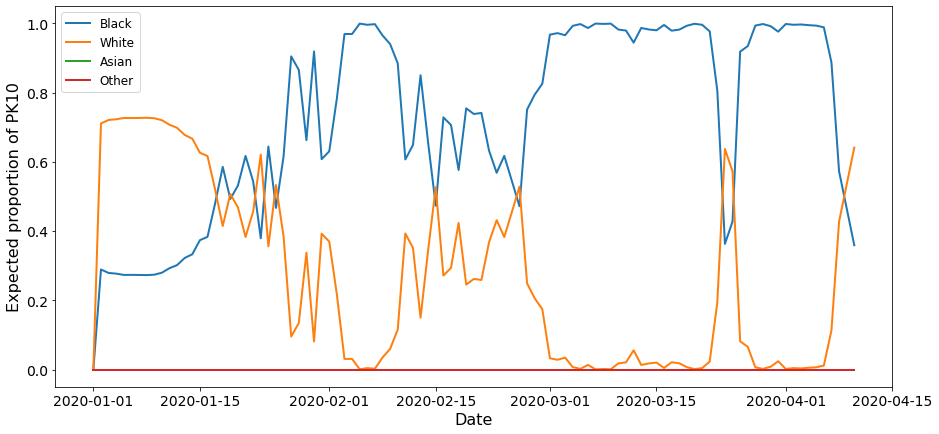

In [8]:
# plot results

fig, ax = plt.subplots(1, 1, figsize=(15,7), sharex=True, sharey=True)

tick_size = 14
label_size = 16
legend_size = 12
line_size = 2

pk_props = [mc.black_PK_prop, mc.white_PK_prop, mc.asian_PK_prop, mc.other_PK_prop]
pk_props_labs = ['Black','White','Asian', 'Other']

for i in range(len(pk_props)):
    stats = mc.get_stats(pk_props[i], [2.5, 97.5])
    ax.plot(pd.to_datetime(stats['date']), stats['mean'].values, label=pk_props_labs[i], linewidth=line_size)

ax.set_ylabel('Expected proportion of PK10', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.legend(loc='upper left', fontsize=legend_size)

ax.set_xlabel('Date', fontsize=label_size)

The results from our example data show that the proportion of the PK10 is not equal between the four groups. At different points in time, Black individuals bear a greater proportion than white individuals and vice versa. In this data (which was randomly generated), there was no Asian or Other race residents in this county (shown below), explaining why those racial group bear none of the PK10 risk.

In [9]:
census[census.fips ==1].groupby('race').agg({"counts":'sum'})

,counts
race,
b,6713
w,17731
